# Unicycle Navigation with Different Volume Penalties

A comparative study of how volume penalty weights affect the behavior of learned control policies.

**Key Concepts:**

**1. Differentiable Reachability Analysis**
For each time step, we compute reachable sets R_t=[l_t,u_t] where:
- l_t is a lower bound vector of state variables
- u_t is an upper bound vector of state variables
- CROWN algorithm provides differentiable bounds w.r.t. controller parameters

**2. Volume Penalty**
- High volume penalty (4.0): Produces tighter, more conservative trajectories
- Low volume penalty (0.05): Allows for more exploration but less verifiable guarantees

**3. Verification-in-the-Loop Training**
- Performs verification during each training iteration
- Loss incorporates safety specifications and bound tightness
- Results in controller with guaranteed safe behavior

In [ ]:
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify.git@newer-jax-verify

# Import necessary libraries

In [15]:
import jax
import jax.numpy as jnp
from typing import List, Callable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import jax_verify
import functools
import optax
from jax import grad, jit
import time
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Neural Network Controller

In [16]:
def relu_nn(params, inputs, v_max=7, omega_max=np.pi):
    for W, b in params[:-1]:
        outputs = jnp.dot(inputs, W) + b
        inputs = jnp.maximum(outputs, 0)
    Wout, bout = params[-1]
    outputs = jnp.dot(inputs, Wout) + bout

    v = jnp.clip(outputs[0], -v_max, v_max)
    omega = jnp.clip(outputs[1], -omega_max, omega_max)

    return jnp.array([v, omega])

def init_network_params(layer_sizes, rng_key):
    params = []
    for i in range(1, len(layer_sizes)):
        in_dim = layer_sizes[i - 1]
        out_dim = layer_sizes[i]
        key, rng_key = jax.random.split(rng_key)
        bound = jnp.sqrt(6.0 / (in_dim + out_dim))
        weights = jax.random.uniform(key, (in_dim, out_dim), minval=-bound, maxval=bound)
        biases = jnp.zeros(out_dim)
        params.append((weights, biases))
    return params

# Unicycle Dynamics Model

In [17]:
class UnicycleModel:
    def __init__(self):
        self.delta_t = 0.1

    def dynamics_step(self, xs, ut):
        x, y, theta = xs
        v, omega = ut

        theta_new = theta + omega * self.delta_t

        x_new = x + v * jnp.cos(theta) * self.delta_t
        y_new = y + v * jnp.sin(theta) * self.delta_t

        return jnp.array([x_new, y_new, theta_new])

# Reachable Set Computation

In [18]:
def step_1(xt, params):
    ut = relu_nn(params, xt)
    return dyn.dynamics_step(xt, ut)

def compute_multistep_reachable_set(initial_state_range, step_fn, params, num_steps):
    initial_state_bounds = jax_verify.IntervalBound(initial_state_range[:, 0], initial_state_range[:, 1])
    state_bounds = initial_state_bounds
    state_ranges = []

    for i in range(num_steps):
        next_state_bounds = jax_verify.backward_crown_bound_propagation(functools.partial(step_fn, params=params), state_bounds)
        state_ranges.append(next_state_bounds)
        state_bounds = next_state_bounds

    return state_ranges

# Loss Functions

In [19]:
def loss_multi_step_reachable_set_volume(reachable_sets):
    volumes = [jnp.prod(set_.upper[:2] - set_.lower[:2]) for set_ in reachable_sets]
    total_volume = jnp.sum(jnp.array(volumes))
    return total_volume

def loss_reach_avoid(controller_params, initial_state_bounds, cost_map, num_steps, volume_penalty_weight=0.05):
    reachable_set = compute_multistep_reachable_set(
        initial_state_bounds,
        functools.partial(step_1),
        controller_params,
        num_steps
    )

    loss_value = 0.0
    volume_loss = loss_multi_step_reachable_set_volume(reachable_set)

    goal_zone = jnp.unravel_index(jnp.argmin(cost_map), cost_map.shape)

    for i, state_bounds in enumerate(reachable_set):
        state_center = (state_bounds.upper + state_bounds.lower) / 2
        x, y = state_center[:2]
        x_idx = jnp.clip(jnp.round(x).astype(int), 0, cost_map.shape[1] - 1)
        y_idx = jnp.clip(jnp.round(y).astype(int), 0, cost_map.shape[0] - 1)

        # Calculate distance to the goal zone
        goal_center = jnp.array([goal_zone[1], goal_zone[0]])
        distance_to_goal = jnp.linalg.norm(state_center[:2] - goal_center)

        # Calculate overlap area with the goal zone
        overlap_lower_goal = jnp.maximum(state_bounds.lower[:2], goal_center - 0.5)
        overlap_upper_goal = jnp.minimum(state_bounds.upper[:2], goal_center + 0.5)
        overlap_width_goal = jnp.maximum(overlap_upper_goal - overlap_lower_goal, 0)
        overlap_area_goal = jnp.prod(overlap_width_goal)

        step_loss = 8.0 * distance_to_goal - 15.0 * overlap_area_goal
        loss_value += step_loss

    combined_loss = loss_value + volume_penalty_weight * volume_loss
    return combined_loss

# Controller Training

In [20]:
def train_controller(params, optimizer, initial_state_range, num_epochs, cost_map, num_steps, volume_penalty_weight=0.05, patience=100, threshold=1e-7):
    opt_state = optimizer.init(params)
    best_loss = float('inf')
    best_params = params
    epochs_without_improvement = 0
    loss_history = []

    partial_loss_fn = functools.partial(loss_reach_avoid, volume_penalty_weight=volume_penalty_weight)

    @jax.jit
    def train_step(params, opt_state):
        loss_value, grads = jax.value_and_grad(partial_loss_fn)(params, initial_state_range, cost_map, num_steps)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for epoch in range(num_epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        loss_history.append(loss_value)

        if loss_value < best_loss:
            best_loss = loss_value
            best_params = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss_value}")

        if epochs_without_improvement >= patience:
            if best_loss - loss_value < threshold:
                print(f"Loss plateaued. Stopping training at epoch {epoch}.")
                break

    return best_params, loss_history

# Visualization Functions

In [21]:
def plot_multistep_samples_and_bounds(initial_state_range, step_fn, num_steps, cost_map, bounds_list=None):
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 3))
    states = [xt]

    for _ in range(num_steps):
        xt1 = jax.vmap(step_fn)(xt)
        states.append(xt1)
        xt = xt1

    plt.figure(figsize=(14, 10))

    all_x = np.concatenate([state[:, 0] for state in states])
    all_y = np.concatenate([state[:, 1] for state in states])
    x_min, x_max = np.min(all_x), np.max(all_x)
    y_min, y_max = np.min(all_y), np.max(all_y)

    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    ax = plt.gca()
    ax.set_facecolor('white')

    if bounds_list is not None:
        for i, bounds in enumerate(bounds_list):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list))
            alpha = 0.5 - (0.3 * i / len(bounds_list))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            plt.gca().add_patch(rect)


    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)

    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)

    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    for i, state in enumerate(states):
        color = distinct_colors[i]

        plt.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   label=f'Step {i}' if i % 3 == 0 or i == len(states)-1 else None,
                   zorder=10,
                   edgecolors='black', linewidths=0.3)

    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                         init_width, init_height,
                         fill=True, facecolor='red', edgecolor='black',
                         linewidth=2, alpha=0.3, zorder=5)
    plt.gca().add_patch(init_rect)
    plt.text(init_x_mid, init_y_mid, 'START',
             ha='center', va='center',
             color='white', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=15)

    goal_x, goal_y = cost_map.shape[1] - 1, 0
    plt.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
               edgecolor='black', linewidth=1.5, zorder=20)
    plt.text(goal_x, goal_y + 0.5, 'GOAL',
             ha='center', va='center',
             color='black', fontweight='bold', fontsize=18,
             bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
             zorder=20)

    plt.xlabel('X Position', fontsize=20)
    plt.ylabel('Y Position', fontsize=20)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.grid(True, linestyle='--', alpha=0.6, zorder=0)

    step_handles = []

    legend_elements = [
        *step_handles,
        Rectangle((0, 0), 1, 1, facecolor=plt.cm.plasma(0.5), edgecolor='black', alpha=0.5, label='Reachable Sets'),
        Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', alpha=0.3, label='Initial State Region'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=18, label='Goal Position')
    ]

    ncol = min(3, max(1, len(legend_elements) // 5))
    plt.legend(handles=legend_elements, loc='upper right', fontsize=16, ncol=ncol,
              framealpha=0.8, edgecolor='black')

    plt.tight_layout()
    plt.savefig('unicycle_navigation.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_loss_history(loss_history):
    plt.figure(figsize=(12, 6))

    plt.plot(loss_history, color='#1f77b4', linewidth=2, alpha=0.8)

    window_size = min(50, len(loss_history) // 10)
    if window_size > 0:
        smoothed_loss = np.convolve(loss_history, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(loss_history)), smoothed_loss,
                color='#ff7f0e', linewidth=3, label=f'Moving Avg (window={window_size})')

    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training Loss Over Time', fontsize=16, pad=20)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.annotate(f'Initial loss: {loss_history[0]:.2f}',
                xy=(0, loss_history[0]),
                xytext=(len(loss_history)*0.05, loss_history[0]*1.1),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    plt.annotate(f'Final loss: {loss_history[-1]:.2f}',
                xy=(len(loss_history)-1, loss_history[-1]),
                xytext=(len(loss_history)*0.8, loss_history[-1]*1.5),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=12)

    plt.legend(fontsize=12)

    if min(loss_history) > 0:
        plt.yscale('log')
        plt.title('Training Loss Over Time (Log Scale)', fontsize=16, pad=20)

    plt.tight_layout()
    plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_combined_outputs(initial_state_range, step_fn1, step_fn2, num_steps, cost_map,
                       bounds_list1, bounds_list2):

    np.random.seed(42)
    xt = np.random.uniform(low=initial_state_range[:, 0], high=initial_state_range[:, 1], size=(1000, 3))

    states1 = [xt.copy()]
    xt1 = xt.copy()
    for _ in range(num_steps):
        xt1 = jax.vmap(step_fn1)(xt1)
        states1.append(xt1)

    states2 = [xt.copy()]
    xt2 = xt.copy()
    for _ in range(num_steps):
        xt2 = jax.vmap(step_fn2)(xt2)
        states2.append(xt2)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

    all_x = np.concatenate([np.concatenate([s[:, 0] for s in states1]),
                           np.concatenate([s[:, 0] for s in states2])])
    all_y = np.concatenate([np.concatenate([s[:, 1] for s in states1]),
                           np.concatenate([s[:, 1] for s in states2])])

    x_min, x_max = np.min(all_x), np.max(all_x)
    y_min, y_max = np.min(all_y), np.max(all_y)

    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1

    xlim = [x_min - x_padding, x_max + x_padding]
    ylim = [y_min - y_padding, y_max + y_padding]

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_ylim(ylim)

    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    distinct_colors = []
    tab_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors)
    tab_colors_b = plt.cm.tab20b(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_b)
    tab_colors_c = plt.cm.tab20c(np.linspace(0, 1, 20))
    distinct_colors.extend(tab_colors_c)

    if bounds_list1 is not None:
        for i, bounds in enumerate(bounds_list1):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list1))
            alpha = 0.5 - (0.3 * i / len(bounds_list1))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            ax1.add_patch(rect)

    for i, state in enumerate(states1):
        color = distinct_colors[i]
        ax1.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   zorder=10, edgecolors='black', linewidths=0.3)

    if bounds_list2 is not None:
        for i, bounds in enumerate(bounds_list2):
            lower = bounds.lower
            upper = bounds.upper

            color = plt.cm.plasma(i / len(bounds_list2))
            alpha = 0.5 - (0.3 * i / len(bounds_list2))

            rect = Rectangle((lower[0], lower[1]),
                            upper[0] - lower[0],
                            upper[1] - lower[1],
                            fill=True,
                            facecolor=color,
                            edgecolor='black',
                            linewidth=1,
                            alpha=alpha,
                            zorder=1)
            ax2.add_patch(rect)

    for i, state in enumerate(states2):
        color = distinct_colors[i]
        ax2.scatter(state[:, 0], state[:, 1], s=7, color=color, alpha=0.8,
                   zorder=10, edgecolors='black', linewidths=0.3)

    init_x_mid = (initial_state_range[0, 0] + initial_state_range[0, 1]) / 2
    init_y_mid = (initial_state_range[1, 0] + initial_state_range[1, 1]) / 2
    init_width = initial_state_range[0, 1] - initial_state_range[0, 0]
    init_height = initial_state_range[1, 1] - initial_state_range[1, 0]

    for ax in [ax1, ax2]:
        init_rect = Rectangle((initial_state_range[0, 0], initial_state_range[1, 0]),
                             init_width, init_height,
                             fill=True, facecolor='red', edgecolor='black',
                             linewidth=2, alpha=0.3, zorder=5)
        ax.add_patch(init_rect)
        ax.text(init_x_mid, init_y_mid, 'START',
                 ha='center', va='center',
                 color='white', fontweight='bold', fontsize=16,
                 bbox=dict(facecolor='red', alpha=0.7, boxstyle='round,pad=0.5'),
                 zorder=15)

        goal_x, goal_y = cost_map.shape[1] - 1, 0
        ax.scatter(goal_x, goal_y, s=400, marker='*', color='gold',
                   edgecolor='black', linewidth=1.5, zorder=20)
        ax.text(goal_x, goal_y + 0.5, 'GOAL',
                 ha='center', va='center',
                 color='black', fontweight='bold', fontsize=16,
                 bbox=dict(facecolor='green', alpha=0.7, boxstyle='round,pad=0.5'),
                 zorder=20)

        ax.grid(True, linestyle='--', alpha=0.6, zorder=0)

    ax1.set_xlabel('X Position', fontsize=16)
    ax1.set_ylabel('Y Position', fontsize=16)
    ax2.set_xlabel('X Position', fontsize=16)

    ax1.set_title('High Volume Penalty (4.0)', fontsize=18)
    ax2.set_title('Low Volume Penalty (0.05)', fontsize=18)

    legend_elements = [
        Rectangle((0, 0), 1, 1, facecolor=plt.cm.plasma(0.5), edgecolor='black', alpha=0.5, label='Reachable Sets'),
        Rectangle((0, 0), 1, 1, facecolor='red', edgecolor='black', alpha=0.3, label='Initial State Region'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor='gold', markersize=25, label='Goal Position')
    ]

    fig.legend(handles=legend_elements, loc='upper center',
              bbox_to_anchor=(0.5, 1.05), ncol=len(legend_elements),
              fontsize=20, framealpha=0.9, edgecolor='black',
              handlelength=3, handleheight=1.0, handletextpad=1.0,
              markerscale=2.0, borderpad=1.2, labelspacing=1.5)

    plt.tight_layout()
    fig.subplots_adjust(top=0.85)

    plt.savefig('combined_unicycle_navigation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run Experiments

Training with High Volume Penalty (weight = 4.0)
Epoch 0, Loss: 37830.74609375
Epoch 100, Loss: 4538.1826171875
Epoch 200, Loss: 3950.955078125
Epoch 300, Loss: 3690.625732421875
Epoch 400, Loss: 3530.4931640625
Epoch 500, Loss: 3415.358642578125
Epoch 600, Loss: 3321.552734375
Epoch 700, Loss: 3238.708251953125
Epoch 800, Loss: 3162.63330078125
Epoch 900, Loss: 3088.575439453125
Epoch 1000, Loss: 3016.978271484375
Epoch 1100, Loss: 2947.06494140625
Epoch 1200, Loss: 2879.39794921875
Epoch 1300, Loss: 2818.2578125
Epoch 1400, Loss: 2768.103271484375
Epoch 1500, Loss: 2735.734619140625
Epoch 1600, Loss: 2728.605712890625
Epoch 1700, Loss: 2727.833984375
Epoch 1800, Loss: 2727.000244140625
Epoch 1900, Loss: 2726.1259765625
Epoch 2000, Loss: 2725.214111328125
Epoch 2100, Loss: 2724.235595703125
Epoch 2200, Loss: 2723.167724609375
Epoch 2300, Loss: 2721.995361328125
Epoch 2400, Loss: 2720.710205078125
Epoch 2500, Loss: 2719.30224609375
Epoch 2600, Loss: 2717.77587890625
Epoch 2700, Loss: 2

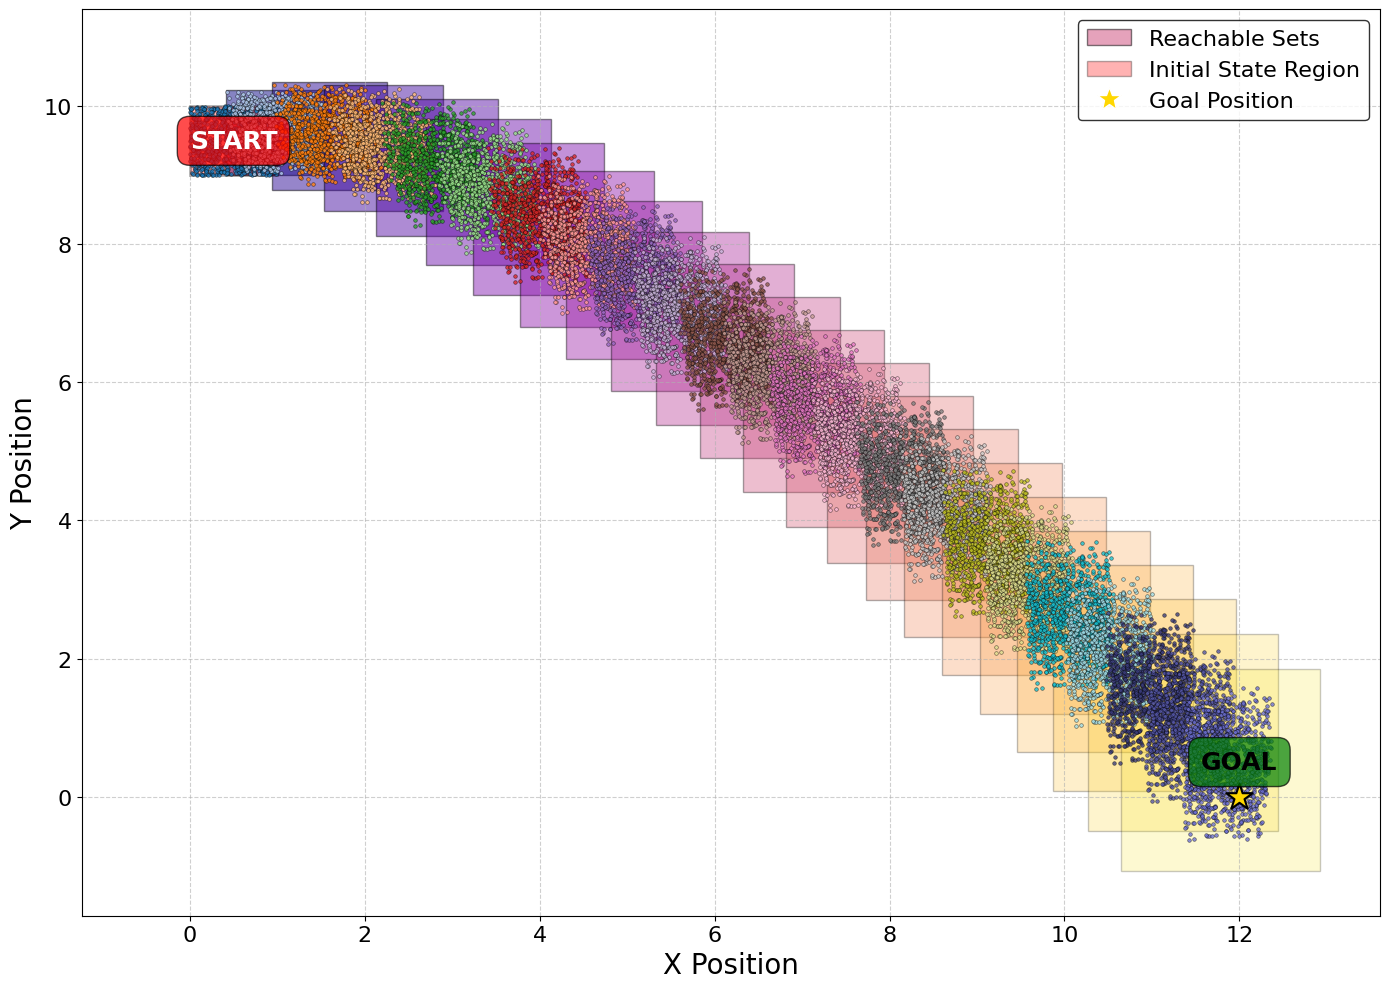

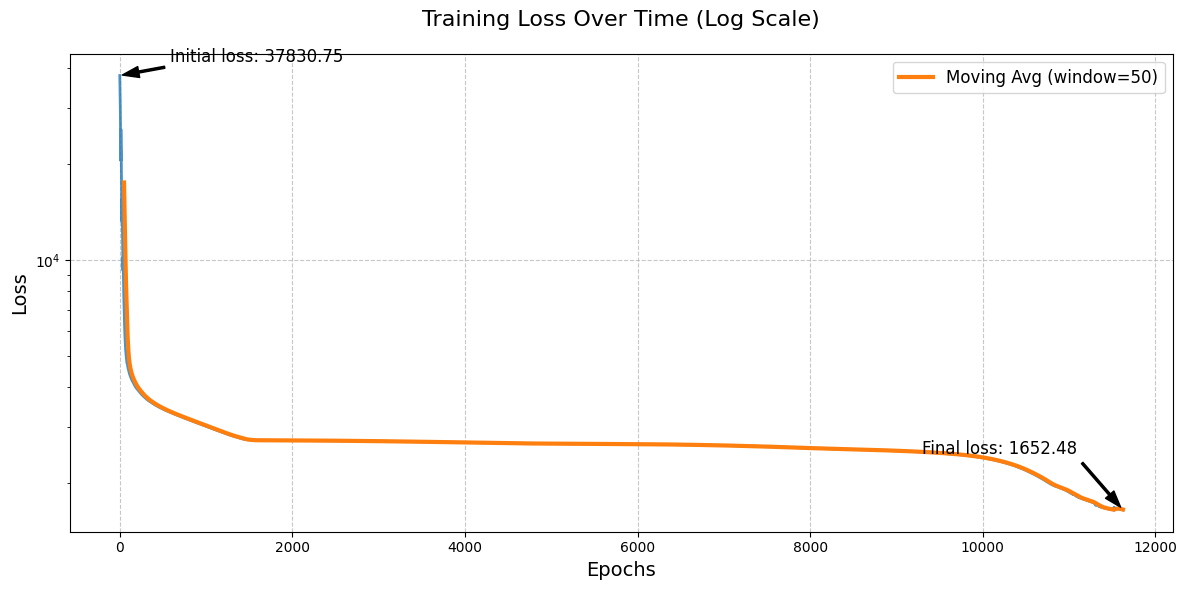

Training with Low Volume Penalty (weight = 0.05)
Epoch 0, Loss: 3379.818359375
Epoch 100, Loss: 2949.484130859375
Epoch 200, Loss: 2743.135009765625
Epoch 300, Loss: 2638.833251953125
Epoch 400, Loss: 2608.302734375
Epoch 500, Loss: 2331.925537109375
Epoch 600, Loss: 1847.381591796875
Epoch 700, Loss: 1517.7110595703125
Epoch 800, Loss: 1462.0245361328125
Epoch 900, Loss: 1445.0804443359375
Epoch 1000, Loss: 1434.974609375
Epoch 1100, Loss: 1424.4102783203125
Epoch 1200, Loss: 1418.1527099609375
Epoch 1300, Loss: 1409.677490234375
Epoch 1400, Loss: 1402.16259765625
Epoch 1500, Loss: 1393.83740234375
Epoch 1600, Loss: 1385.06494140625
Epoch 1700, Loss: 1376.3062744140625
Epoch 1800, Loss: 1367.9473876953125
Epoch 1900, Loss: 1359.3017578125
Epoch 2000, Loss: 1351.5469970703125
Epoch 2100, Loss: 1343.1925048828125
Epoch 2200, Loss: 1333.4713134765625
Epoch 2300, Loss: 1323.296875
Epoch 2400, Loss: 1312.55419921875
Epoch 2500, Loss: 1303.9783935546875
Epoch 2600, Loss: 1297.3355712890625


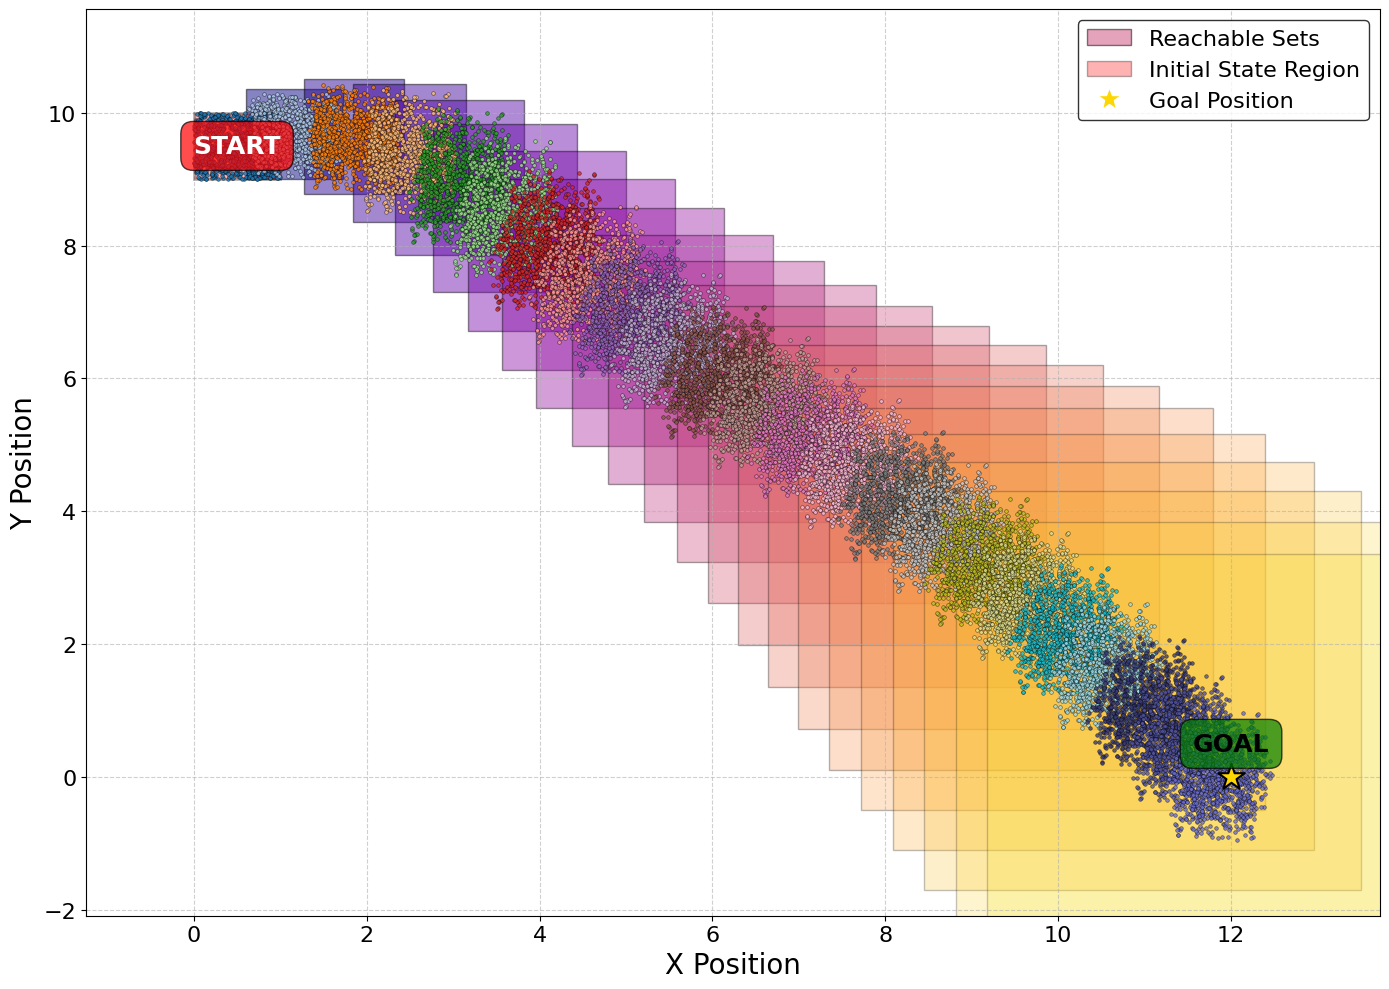

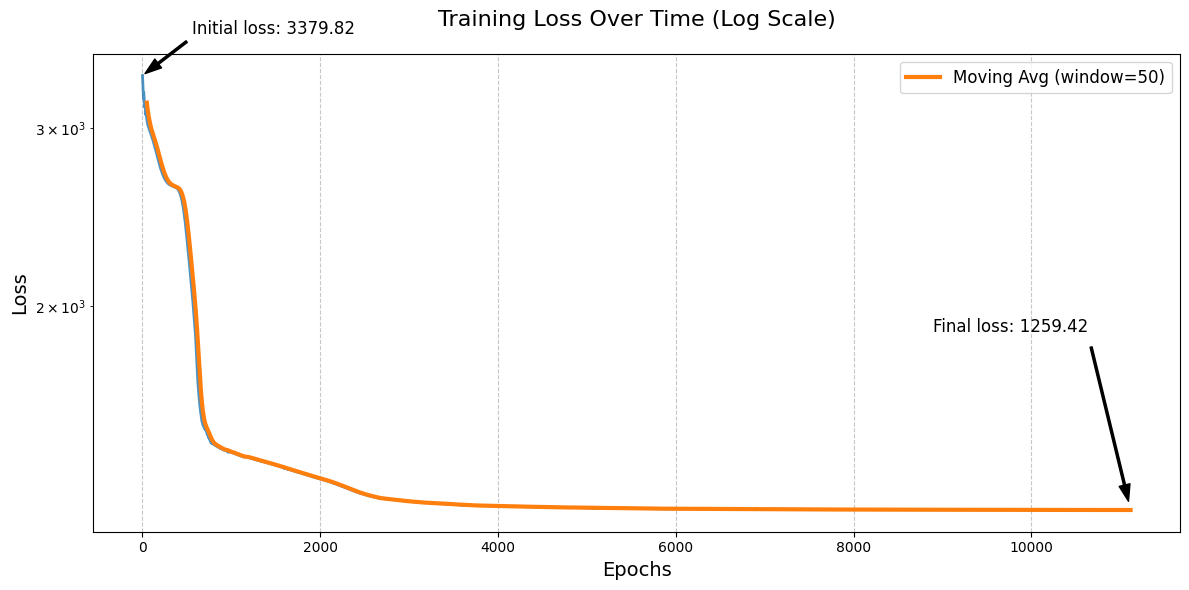

Comparing Both Controllers


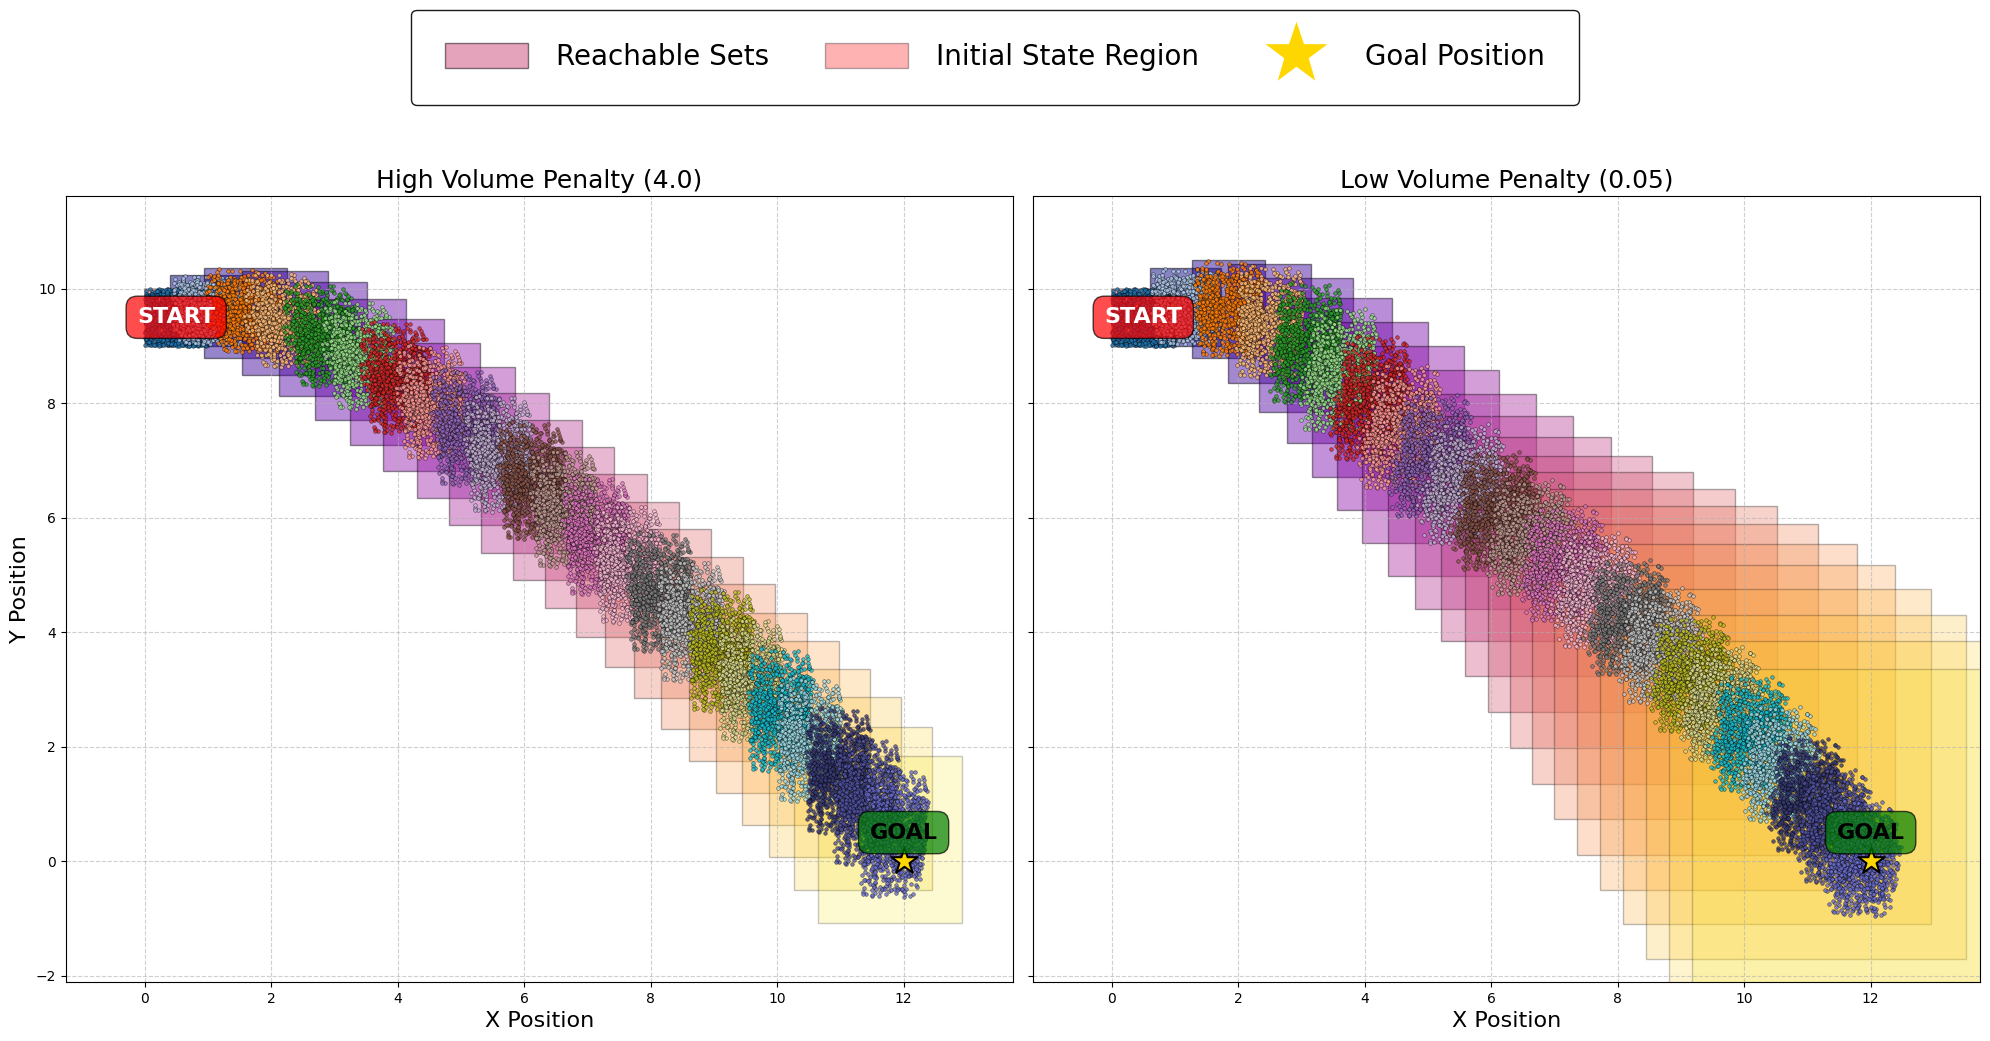

In [22]:
layer_sizes = [3, 16, 32, 16, 2]
rng_key = jax.random.PRNGKey(0)
dyn = UnicycleModel()

initial_state_range = np.array([
    [0, 1],
    [9, 10],
    [0, np.pi/6]
])

grid_size = 13
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)
cost_map = 1.0 - (X + Y) / 2

goal_zone = (0, grid_size - 1)
cost_map[goal_zone] = 0

num_steps = 22
learning_rate = 0.0001
optimizer = optax.adam(learning_rate)
num_epochs = 20000

print("================================================================")
print("Training with High Volume Penalty (weight = 4.0)")
print("================================================================")

high_penalty_params = init_network_params(layer_sizes, jax.random.PRNGKey(0))
trained_params1, loss_history1 = train_controller(
    high_penalty_params,
    optimizer,
    jnp.array(initial_state_range),
    num_epochs,
    cost_map,
    num_steps,
    volume_penalty_weight=4.0
)
print("Training completed.")

print("Computing reachable sets using high volume penalty controller...")
output_ranges1 = compute_multistep_reachable_set(
    initial_state_range, step_1, trained_params1, num_steps
)

print("Plotting results for high volume penalty controller...")
plot_multistep_samples_and_bounds(
    initial_state_range,
    functools.partial(step_1, params=trained_params1),
    num_steps,
    cost_map,
    bounds_list=output_ranges1
)
plot_loss_history(loss_history1)

print("================================================================")
print("Training with Low Volume Penalty (weight = 0.05)")
print("================================================================")

low_penalty_params = init_network_params(layer_sizes, jax.random.PRNGKey(0))
trained_params, loss_history = train_controller(
    low_penalty_params,
    optimizer,
    jnp.array(initial_state_range),
    num_epochs,
    cost_map,
    num_steps,
    volume_penalty_weight=0.05
)
print("Training completed.")

print("Computing reachable sets using low volume penalty controller...")
output_ranges = compute_multistep_reachable_set(
    initial_state_range, step_1, trained_params, num_steps
)

print("Plotting results for low volume penalty controller...")
plot_multistep_samples_and_bounds(
    initial_state_range,
    functools.partial(step_1, params=trained_params),
    num_steps,
    cost_map,
    bounds_list=output_ranges
)
plot_loss_history(loss_history)

print("================================================================")
print("Comparing Both Controllers")
print("================================================================")

plot_combined_outputs(
    initial_state_range,
    functools.partial(step_1, params=trained_params1),  # High volume penalty
    functools.partial(step_1, params=trained_params),   # Low volume penalty
    num_steps,
    cost_map,
    output_ranges1,
    output_ranges
)